# HW 1

## Import libraries

In [ ]:
display_figures = True

def display_correlation_matrix(X,y):
    if not display_figures:
        return

    Xy = pd.concat([X, y], axis=1)
    corr = Xy.corr()
    f = plt.figure(figsize=(20, 20))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(Xy.shape[1]), Xy.columns, fontsize=14, rotation=90)
    plt.yticks(range(Xy.shape[1]), Xy.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

In [2]:
import pandas as pd # data analysis and manipulation tool
import numpy as np # Numerical computing tools
import matplotlib.pyplot as plt # another visualization library
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from skrebate import ReliefF
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder 

warnings.filterwarnings('ignore')

## Part 1 - load the data


In [3]:
file = 'virus_hw2.csv'

In [4]:
df = pd.read_csv(file)

In [5]:
df.drop(labels=['Address', 'Job', 'PatientID'], axis=1, inplace=True)

## Part 2 - Split to train, validate and test sets

The ratio is 70% for training, 15% for validating and 15% for testing.

In [6]:
X = df.drop(labels=['TestResultsCode'], axis=1)
y = df[['TestResultsCode']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2


## Part 3 - Fix the data types

Fixing CurrentLocation lat long type - separate into 2 features

In [7]:
label_categories = [
    'not_detected_Spreader_NotatRisk',
    'not_detected_NotSpreader_atRisk',
    'not_detected_NotSpreader_NotatRisk',
    'not_detected_Spreader_atRisk',
    'cold_NotSpreader_NotatRisk',
    'cold_Spreader_NotatRisk',
    'cold_Spreader_atRisk',
    'cold_NotSpreader_atRisk',
    'flue_NotSpreader_NotatRisk',
    'flue_NotSpreader_atRisk',
    'flue_Spreader_NotatRisk',
    'covid_NotSpreader_atRisk',
    'covid_Spreader_NotatRisk',
    'flue_Spreader_atRisk',
    'covid_NotSpreader_NotatRisk',
    'covid_Spreader_atRisk',
    'cmv_NotSpreader_NotatRisk',
    'cmv_Spreader_atRisk',
    'cmv_NotSpreader_atRisk',
    'cmv_Spreader_NotatRisk',
    'measles_Spreader_NotatRisk',
    'measles_NotSpreader_NotatRisk',
    'measles_NotSpreader_atRisk',
    'measles_Spreader_atRisk',
]

convert_features_dict = {
    'BloodType': pd.CategoricalDtype(categories=['AB-', 'A+', 'AB+', 'A-', 'B-', 'O-', 'B+', 'O+']),
    'SyndromeClass': pd.CategoricalDtype(categories=range(1,5))
}

convert_label_dict = {
    'TestResultsCode': pd.CategoricalDtype(categories=label_categories)
}

In [8]:
def fix_data_types(X):
    return X.astype(convert_features_dict)

data_types_transofrmer = FunctionTransformer(fix_data_types)

In [9]:
def fix_label_type(y):
    y = y.astype(convert_label_dict)
    y.update(y[['TestResultsCode']].apply(lambda x: x.cat.codes))
    y = y.astype({'TestResultsCode': int})
    return y

label_transformer = FunctionTransformer(fix_label_type)

### Handle Sex

In [10]:
def handle_sex_type(X):
    return X.replace({'Sex': {'F': -1, 'M': 1}})

sex_type_transformer = FunctionTransformer(handle_sex_type)


### Handle BloodType

In [11]:
def handle_blood_type(X):
    return pd.get_dummies(X, columns=["BloodType"], prefix=["BloodType"])

blood_type_transformer = FunctionTransformer(handle_blood_type)


### Handle DateOfPCRTest

In [12]:
def handle_date_of_pcr_test(X):
    X['DateOfPCRTest'] = pd.to_datetime(X['DateOfPCRTest'], infer_datetime_format=True)
    X['DateOfPCRTest'] = X['DateOfPCRTest'].values.astype(float)
    X['DateOfPCRTest'].values[X['DateOfPCRTest'].values < 0] = np.nan
    return X

date_of_pcr_test_type_transformer = FunctionTransformer(handle_date_of_pcr_test)

### Handle SyndromeClass

In [13]:
def handle_syndrome_class(X):
    return pd.get_dummies(X, columns=["SyndromeClass"], prefix=["SyndromeClass"])

syndrome_class_transformer = FunctionTransformer(handle_syndrome_class)


### Handle location

we separate the location into 2 features for longitude and latitude.

In [14]:
def handle_location(X):
    long_lat_df = X['CurrentLocation'].str.strip('(Decimal').str.split(', ', expand=True).rename(columns={0:'Lat', 1:'Long'})
    X['CurrentLocation_Lat'] = long_lat_df['Lat'].str.strip("')")
    X['CurrentLocation_Long'] = long_lat_df['Long'].str.strip("Decimal('").str.rstrip("'))")

    convert_dict = {
        'CurrentLocation_Lat': float,
        'CurrentLocation_Long': float,
    }

    X = X.astype(convert_dict)
    return X.drop(labels=['CurrentLocation'], axis=1)

location_transformer = FunctionTransformer(handle_location)

### Handle symptoms

We create a one-hot vector of all symptoms and remove the old mixed feature.

In [15]:
def handle_symptoms(X):
    splitted_df = X['SelfDeclarationOfIllnessForm'].str.split(';', expand=True)
    values = splitted_df.values.flatten()
    unique_values = pd.unique(values).tolist()
    stripped_unique_values = [str(val).strip(' ') for val in unique_values]

    # Split by ; to create a list for each row
    X['SelfDeclarationOfIllnessForm_list'] = X['SelfDeclarationOfIllnessForm'].str.split(';')

    # Replace NAN values with empty list
    isna = X['SelfDeclarationOfIllnessForm_list'].isna()
    X.loc[isna, 'SelfDeclarationOfIllnessForm_list'] = pd.Series([['nan']] * isna.sum()).values

    # strip whitespaces
    X['SelfDeclarationOfIllnessForm_list'] = [[str(val).strip() for val in list(symptom_list)]
                                              for symptom_list in X['SelfDeclarationOfIllnessForm_list'].values]

    # Create columns
    for column_name in stripped_unique_values:
        X[column_name] = X['SelfDeclarationOfIllnessForm_list'].map(lambda l: 1 if column_name in l else 0)

    # Rename no symptoms column
    # Drop irrelevant features
    X = X.rename(columns={'nan': 'No_Symptoms'})\
        .drop(labels=['SelfDeclarationOfIllnessForm','SelfDeclarationOfIllnessForm_list'], axis=1)
    return X

symptoms_transformer = FunctionTransformer(handle_symptoms)

In [16]:
features_data_types_pipeline = Pipeline([
    ('handle_sex_type', sex_type_transformer),
    ('handle_blood_type', blood_type_transformer),
    ('handle_date_of_pcr_test', date_of_pcr_test_type_transformer),
    ('handle_syndrome_class', syndrome_class_transformer),
    ('handle_location', location_transformer),
    ('handle_symptoms', symptoms_transformer)
])

## Part 3 - Transformations


### Imputation

In [17]:
numeric_features = [
    'AvgHouseholdExpenseOnPresents', 
    'AvgHouseholdExpenseOnSocialGames',
    'AvgHouseholdExpenseParkingTicketsPerYear',
    'AvgMinSportsPerDay',
    'AvgTimeOnSocialMedia',
    'AvgTimeOnStuding',
    'BMI',
    'DateOfPCRTest',
    'NrCousins',
    'StepsPerYear',
    'TimeOnSocialActivities',
    'pcrResult1',
    'pcrResult2',
    'pcrResult3',
    'pcrResult4',
    'pcrResult5',
    'pcrResult6',
    'pcrResult7',
    'pcrResult8',
    'pcrResult9',
    'pcrResult10',
    'pcrResult11',
    'pcrResult12',
    'pcrResult13',
    'pcrResult14',
    'pcrResult15',
    'pcrResult16',
    'CurrentLocation_Lat',
    'CurrentLocation_Long']

def impute_by_mean(X):
    for column in numeric_features:
        mean = X[column].mean()
        X[column] = X[column].fillna(mean)

categorical_features = [
    'AgeGroup',
    'DisciplineScore', 
    'HappinessScore', 
    'Sex',
]

def impute_by_most_common(X):
    for column in categorical_features:
        mode = X[column].mode()
        X[column] = X[column].fillna(mode[0])
        
def impute_values(X):
    impute_by_mean(X)
    impute_by_most_common(X)
    return X

imputation_transformer = FunctionTransformer(impute_values)

### Outlier Detection


#### OutlierClipper transformer

In [18]:
class OutlierClipper:
    def __init__(self):
        self._feature_map = {}

    def fit(self, data):
        features = list(data.columns)
        for feature in features:
            f_q1 = data[feature].quantile(0.25)
            f_q3 = data[feature].quantile(0.75)
            f_iqr = f_q3 - f_q1
            self._feature_map[feature] = (f_q1 - (1.5 * f_iqr), f_q3 + (1.5 * f_iqr))
        return self

    def transform(self, data):
        data_copy = data.copy()
        for feature in self._feature_map.keys():
            data_copy[feature] = data_copy[feature].clip(lower=self._feature_map[feature][0],
                                                         upper=self._feature_map[feature][1])
        return data_copy

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [19]:
continous_features = ['StepsPerYear',
                    'TimeOnSocialActivities',
                    'AvgHouseholdExpenseOnPresents',
                    'AvgHouseholdExpenseOnSocialGames',
                    'AvgHouseholdExpenseParkingTicketsPerYear',
                    'AvgMinSportsPerDay',
                    'AvgTimeOnSocialMedia',
                    'AvgTimeOnStuding',
                    'BMI',
                    'pcrResult1',
                    'pcrResult10',
                    'pcrResult11',
                    'pcrResult12',
                    'pcrResult13',
                    'pcrResult14',
                    'pcrResult15',
                    'pcrResult16',
                    'pcrResult2',
                    'pcrResult3',
                    'pcrResult4',
                    'pcrResult5',
                    'pcrResult6',
                    'pcrResult7',
                    'pcrResult8',
                    'pcrResult9']

In [20]:
def clip_outliers(X):
    outlier_clipper = OutlierClipper()
    X[continous_features] = outlier_clipper.fit_transform(X[continous_features])

    return X

outlier_transformer = FunctionTransformer(clip_outliers)


## Normalization

In [21]:
positive_scaled_features = ['AgeGroup',
    'AvgHouseholdExpenseOnPresents',
    'AvgHouseholdExpenseOnSocialGames',
    'AvgHouseholdExpenseParkingTicketsPerYear',
    'AvgMinSportsPerDay',
    'AvgTimeOnSocialMedia',
    'AvgTimeOnStuding',
    'BMI',
    'DateOfPCRTest',
    'DisciplineScore',
    'HappinessScore',
    'NrCousins',
    'StepsPerYear',
    'TimeOnSocialActivities',
    'pcrResult14',
    'pcrResult16']

negative_scaled_features = [
    'pcrResult1',
    'pcrResult10',
    'pcrResult11',
    'pcrResult12',
    'pcrResult13',
    'pcrResult15',
    'pcrResult2',
    'pcrResult3',
    'pcrResult4',
    'pcrResult5',
    'pcrResult6',
    'pcrResult7',
    'pcrResult8',
    'pcrResult9',
]

def normalize_data(X):
    minMaxScaler = MinMaxScaler()
    X[positive_scaled_features] = minMaxScaler.fit_transform(X[positive_scaled_features])

    maxAbsScale = MaxAbsScaler()
    X[negative_scaled_features] = maxAbsScale.fit_transform(X[negative_scaled_features])

    # Normalize longitude and latitude

    X['CurrentLocation_Lat'] /= 180
    X['CurrentLocation_Long'] /= 180

    return X

normalize_transformer = FunctionTransformer(normalize_data)


# Feature Selection

In [22]:
diseases = ['cmv', 'cold', 'covid', 'flue', 'measles', 'not_detected']
labels = pd.DataFrame()
labels['is_spreader'] = pd.Series([0 if 'NotSpreader' in row else 1 for row in df['TestResultsCode']])
labels['is_at_risk'] = pd.Series([0 if 'NotatRisk' in row else 1 for row in df['TestResultsCode']])
for d in diseases:
    labels[d] = pd.Series([1 if d in row else 0 for row in df['TestResultsCode']])


## Feature Selection with Filter

In [23]:
def select_features_filter(X):
    relief = RFE(ReliefF(), n_features_to_select=20, step = 0.5, verbose=True)
    feature_selector = relief.fit(X, df['TestResultsCode'].values.codes)
    print('Selected Features:', X.columns[feature_selector.support_])
    return feature_selector

## Feature selection with Wrapper

In [24]:
def select_features_wrapper(X,y):
    svc = SVC(gamma='auto')
    # knn = KNeighborsClassifier(n_neighbors=3)
    sfs = SequentialFeatureSelector(svc, k_features=20, forward=False, floating=False, verbose=2, cv=0, n_jobs=-1)
    sfs.fit(X, y)

    print(sfs.k_feature_names_)

    return sfs

# Pipeline Definition

In [25]:
data_preperation_pipelines = Pipeline([
    ('feature_types', features_data_types_pipeline),
    ('feature_imputation', imputation_transformer),
    ('outlier_clipping', outlier_transformer),
    ('normalization', normalize_transformer)
])

In [26]:
X_train_prepared, y_train_prepared = data_preperation_pipelines.fit_transform(X_train, y_train), label_transformer.fit_transform(y_train)
X_validation_prepared = data_preperation_pipelines.fit_transform(X_val, y_train)
X_test_prepared = data_preperation_pipelines.fit_transform(X_test, y_train)

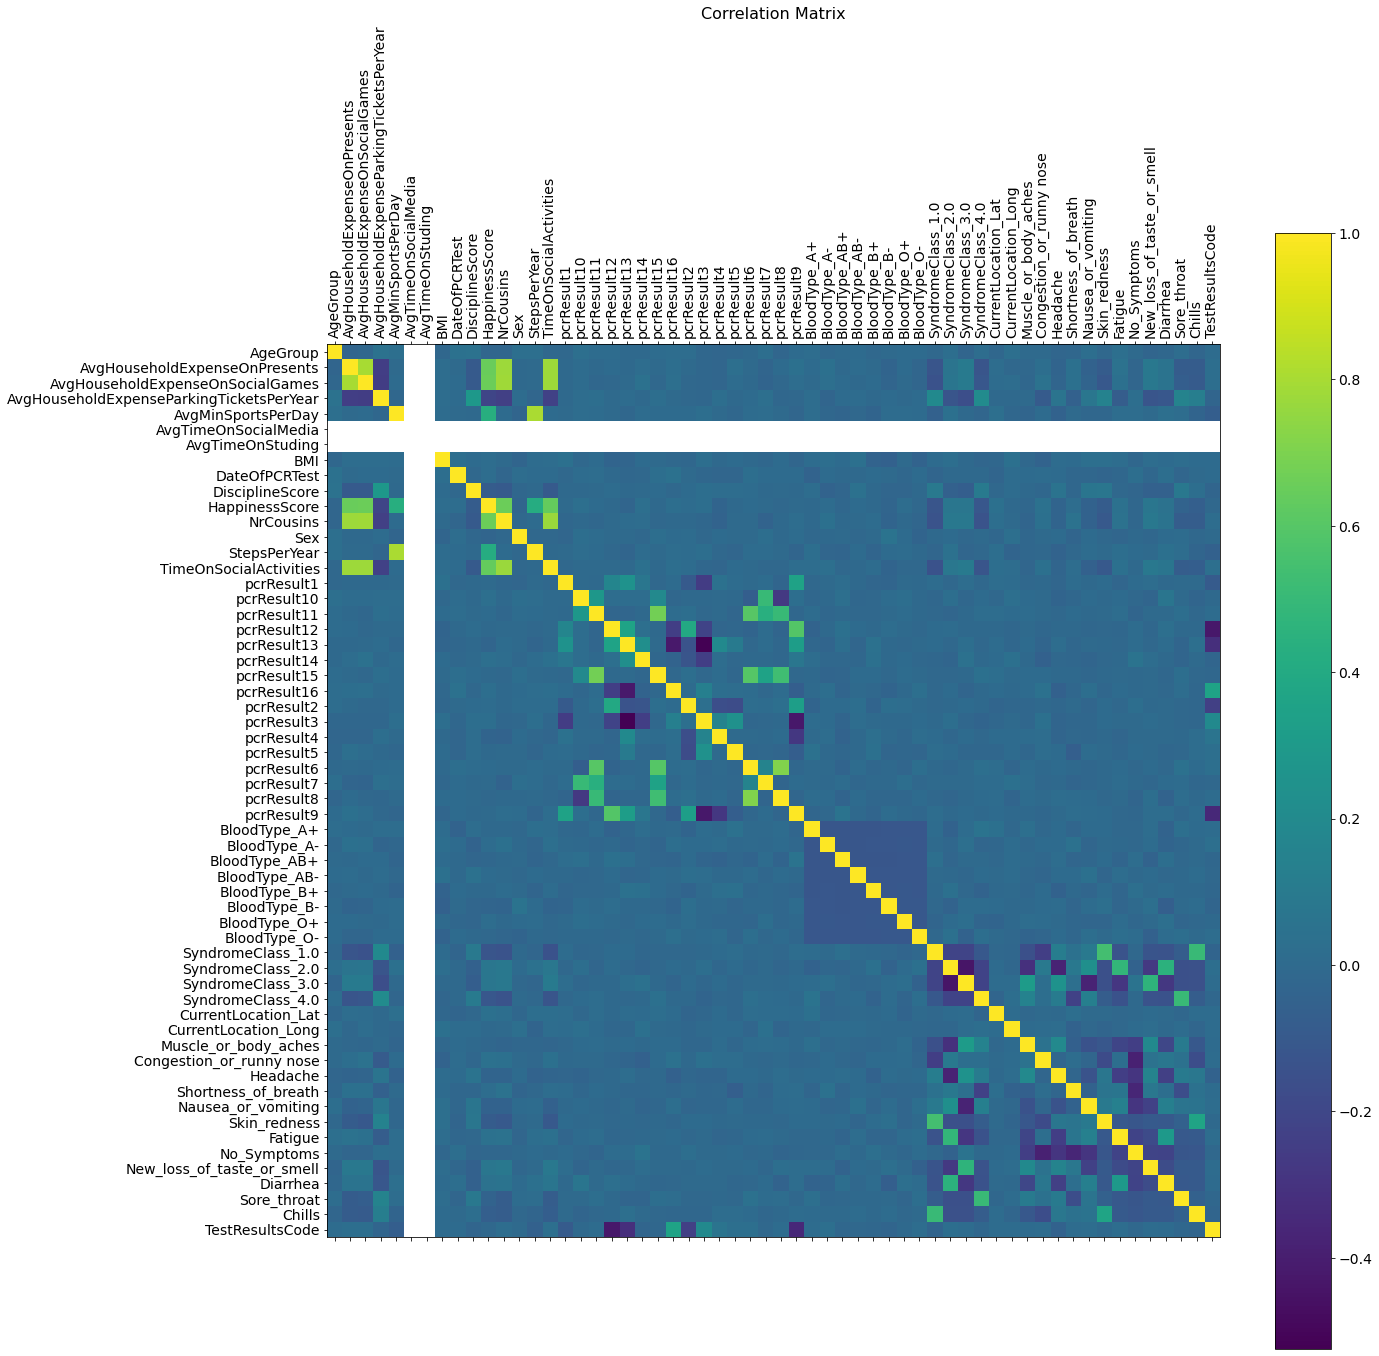

In [27]:
display_correlation_matrix(X_train_prepared, y_train_prepared)

In [28]:
y_train_prepared.dtypes

TestResultsCode    int32
dtype: object